# 4: Data pre-processing

In [1]:
# Importing dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Loading the data
df = pd.read_csv('results.txt')
df.columns = ['id', 'num', 'image', 'label', 'time']
df.drop(["num"], axis=1, inplace=True)

# Removal of outliers
print(len(df))
df.drop(df[df['time'] < 0.2].index, inplace=True)
df.drop(df[df['time'] > 3].index, inplace=True)
print(len(df))

# Normalization of reaction times for each person
df['mean'] = df.groupby('id')['time'].transform('mean')
df['min'] = df.groupby('id')['time'].transform('min')
df['max'] = df.groupby('id')['time'].transform('max')
df['normalized'] = (df['time']-df['min']) / (2*(df['max'] - df['min']))

df['SmileNorm'] = 1-df['normalized']
df['score'] = df['normalized']
df['score'][df['label'] == "Smiling"] = df['SmileNorm']

3112
3091


<ipython-input-1-c733e8f08c33>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'][df['label'] == "Smiling"] = df['SmileNorm']


In [2]:
df.head()

,id,image,label,time,mean,min,max,normalized,SmileNorm,score
0,7,55_1_0_20170103183939755.jpg.chip.jpg,Smiling,0.7776,0.826893,0.4476,2.2428,0.091912,0.908088,0.908088
1,7,42_1_0_20170105173320357.jpg.chip.jpg,Smiling,0.5956,0.826893,0.4476,2.2428,0.041221,0.958779,0.958779
2,7,26_1_1_20170112205848764.jpg.chip.jpg,Smiling,0.6308,0.826893,0.4476,2.2428,0.051025,0.948975,0.948975
3,7,28_0_3_20170113153014880.jpg.chip.jpg,Not smiling,0.6131,0.826893,0.4476,2.2428,0.046095,0.953905,0.046095
4,7,50_0_0_20170113184603160.jpg.chip.jpg,Not smiling,0.7651,0.826893,0.4476,2.2428,0.088430,0.911570,0.088430


Text(0.5, 0, 'Index')

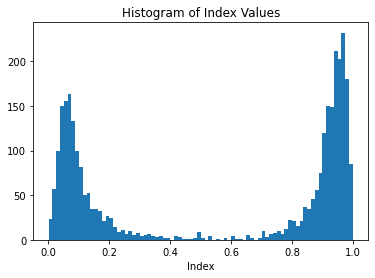

In [3]:
# Plotting histogram of index values
plt.title('Histogram of Index Values')
plt.hist(df['score'], bins = 80)
plt.xlabel('Index')

# 5: PCA and feature selection

In [10]:
# import libraries
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [11]:
# Loading the images
images = [cv2.imread(file) for file in glob.glob("SampledPhotos/*.jpg.chip.jpg")]
image_names = [str(file).split('\\')[1] for file in glob.glob("SampledPhotos/*.jpg.chip.jpg")]
im = np.array(images)

print(len(images))
print(images[0].shape)

398
(200, 200, 3)


In [12]:
# Convert images to 1D arrays, and combine all images in one 2D array
big_im = np.zeros([120000,len(images)])
for i in range(len(images)):
    big_im[:,i] = images[i].reshape(120000)

In [13]:
# Get the means of each pixel and subtract mean from every image
means = np.mean(big_im, axis=1)
print(means.shape)

subtracted_mean = (big_im.T - means).T

(120000,)


In [14]:
# run pca
pca = PCA()

S = pca.fit_transform(subtracted_mean)
print(S.shape)

(120000, 398)
(398, 398)


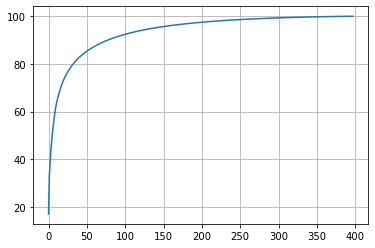

In [15]:
# plot variance of PCA components
variance = pca.explained_variance_ratio_

plt.grid()
plt.plot(np.cumsum(variance)*100)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

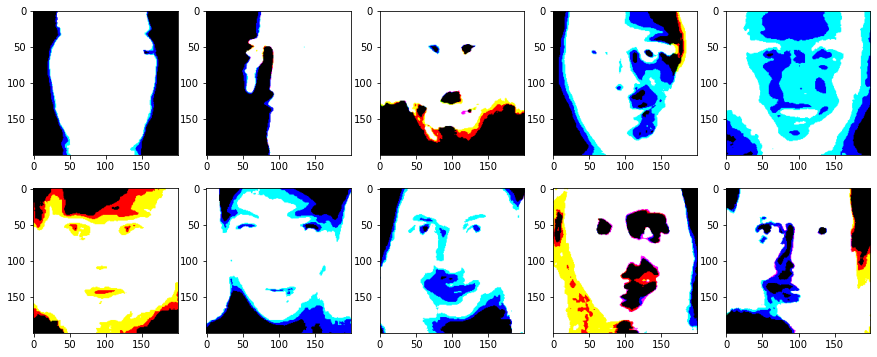

In [16]:
# Convert the components to 200x200x3 image shapes, and plot the first 10

pca_im = S[:,0].reshape([200,200,3])
pca_ims = S.reshape([200,200,3,len(images)])
pca_sub = ((means - S.T).T).reshape([200,200,3,len(images)])
    
fig = plt.figure(figsize=(15,6))
columns = 5
rows = 2
for i in range(columns*rows):
    img = pca_sub[:,:,:,i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()

# 6: Feature Selection

In [208]:
# Calculate number of features needed to reach threshold
# Using our own forward selection method
threshold = 0.90

for i in range(len(variance)):
    
    if sum(variance[0:i+1]) >= threshold:
        num_features = i + 1
        break
print(num_features)

79


In [209]:
# Extract subset of PC's

features = S[:,0:num_features]
print(features.shape)

(120000, 79)


# 7: Linear Regression Model

In [200]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score as acc
from sklearn.feature_selection import SequentialFeatureSelector as sfs

In [206]:
# Create a new dataframe with all the image names
df2 = pd.DataFrame(image_names)
df2.columns = (["image"])

# Add the scores for each person to the dataframe
count = 1
for i in df.groupby("id"):
    grouped_df = i[1][["image","score"]]
    grouped_df.columns = ['image', 'score'+str(count)]
    df2 = pd.merge(df2, grouped_df,how="left", on=["image"])
    count += 1
    
# Take the average score
df2['average'] = df2.mean(numeric_only=True, axis=1)
df2.head()

,image,score1,score2,score3,score4,score5,score6,score7,score8,average
0,20_0_0_20170104230048181.jpg.chip.jpg,0.035245,0.057297,0.078916,0.367870,0.052935,0.083465,0.035031,0.074326,0.098136
1,20_0_1_20170116010734667.jpg.chip.jpg,0.092742,0.839078,0.878550,0.111018,0.943465,NaN,0.884159,0.909813,0.665546
2,20_1_0_20170104021334149.jpg.chip.jpg,0.218306,0.035728,0.043450,0.085339,0.068924,0.082492,0.038197,0.083955,0.082049
3,20_1_0_20170113005610158.jpg.chip.jpg,0.789104,0.865095,0.953187,0.197193,0.908860,0.808310,0.927500,0.118308,0.695945
4,20_1_2_20170108224234471.jpg.chip.jpg,0.885110,0.994107,0.949461,0.919981,0.989179,0.941248,0.946870,0.939748,0.945713


In [ ]:
# Train/test split
X = big_im.T
y = df2[['average']].to_numpy()

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [58]:
# Linear model hvor vi bruger all PCA fra første feature selection

#scale the training and testing data
pca = PCA(n_components = num_features)
X_reduced_train = pca.fit_transform(scale(X_train))
X_reduced_test = pca.transform(scale(X_test))[:,:num_features]
print('Training dataset shape:', X_reduced_train.shape, y_train.shape)
print('Testing dataset shape:', X_reduced_test.shape, y_test.shape)

#train PCR model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:num_features], y_train)

#calculate RMSE
pred = regr.predict(X_reduced_test)
np.sqrt(mean_squared_error(y_test, pred))

0.24441959623166162

In [210]:
results = []
for i in range(1,50):
    print(i)
    # Build RF classifier to use in feature selection
    regr = LinearRegression()
    
    # Build step forward feature selection
    sfs1 = sfs(regr, n_features_to_select=i, direction="forward", cv=5)
    

    # Perform SFFS
    sfs1 = sfs1.fit(X_reduced_train, y_train)
    #print(sfs1.get_support())
    
    regr.fit(X_reduced_train[:,sfs1.get_support()], y_train)

    #calculate RMSE
    pred = regr.predict(X_reduced_test[:,sfs1.get_support()])
    print(np.sqrt(mean_squared_error(y_test, pred)))
    results.append(np.sqrt(mean_squared_error(y_test, pred)))

1
0.35850026294827453
2
0.3390121374367671
3
0.3082707949301668
4
0.29735914838085165
5
0.29023144210434937
6
0.29581108898497094
7
0.2882148863583669
8
0.2902317520975963
9
0.29104613082292874
10
0.2791174753110844
11
0.27422993894339454
12
0.27267966554056233
13
0.27084853940229753
14
0.27077075305892395
15
0.26405311162474704
16
0.26873661169262114
17
0.2704451610895559
18
0.27068951676204983
19
0.2705258539132253
20
0.26621790576465787
21
0.25833406400738185
22
0.26066477101431856
23
0.25392452779371466
24
0.2501801302464764
25
0.24363470994234193
26
0.24279440444924183
27
0.2419507282629963
28
0.2426481386610444
29
0.24126772025327228
30
0.24120757137627818
31
0.24174405472490415
32
0.23745359553956702
33
0.2356058076517847
34
0.23723291539957342
35
0.23990623673148725
36
0.23787552363558545
37
0.23607295920377971
38
0.2347075981772234
39
0.23589238677300106
40
0.23504176902383378
41
0.23597785018650616
42
0.23663540253952264
43
0.2382104526751294
44
0.2401226544339569
45
0.240992

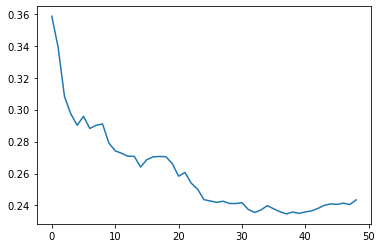

In [211]:
plt.plot(results)

In [212]:
# Build step forward feature selection
sfs2 = sfs(regr, n_features_to_select=32, direction="forward", cv=5)

# Perform SFFS
sfs2 = sfs2.fit(X_reduced_train, y_train)
#print(sfs1.get_support())

regr.fit(X_reduced_train[:,sfs2.get_support()], y_train)
pred = regr.predict(X_reduced_test[:,sfs2.get_support()])
print(np.sqrt(mean_squared_error(y_test, pred)))

0.23745359553956702


In [213]:
for i in range(10):
    print(f"For picture {i}: predicted {pred[i]} and real answer is {y_test[i]}")

For picture 0: predicted [0.48895745] and real answer is [0.96310588]
For picture 1: predicted [0.49992752] and real answer is [0.4003425]
For picture 2: predicted [0.91603765] and real answer is [0.92071789]
For picture 3: predicted [0.94331303] and real answer is [0.92613389]
For picture 4: predicted [0.73192741] and real answer is [0.94844121]
For picture 5: predicted [0.31433869] and real answer is [0.50679443]
For picture 6: predicted [0.3993945] and real answer is [0.32652145]
For picture 7: predicted [0.86370603] and real answer is [0.9533617]
For picture 8: predicted [0.74589367] and real answer is [0.93422207]
For picture 9: predicted [0.15678744] and real answer is [0.47397688]


# 8: Generate samples

In [214]:
S2 = pca.fit_transform(X_train.T)

In [215]:
xs = []
for y in np.arange(0,1.25,0.25):
    alpha = (y - np.sum(regr.intercept_)) / np.sum(abs(regr.coef_))
    x = alpha*regr.coef_
    xs.append(x)
    print(x)

[[-0.00365258  0.00245236 -0.00567682  0.01489427  0.01243239  0.01143499
  -0.00740858  0.01736878 -0.04296446 -0.03143979 -0.01689756 -0.00656624
   0.00916443 -0.0129433   0.01130956  0.01519844 -0.00737207 -0.01319082
   0.01102424 -0.01347955 -0.02137347  0.01917972  0.01331016 -0.02662152
  -0.02391737  0.01669991 -0.01928241 -0.02341223 -0.03035787  0.02326755
  -0.04008313 -0.03157894]]
[[-0.0020101   0.00134959 -0.00312409  0.00819667  0.00684184  0.00629295
  -0.00407711  0.00955845 -0.02364436 -0.01730206 -0.00929913 -0.00361356
   0.0050434  -0.007123    0.00622392  0.00836406 -0.00405702 -0.00725922
   0.0060669  -0.00741812 -0.01176232  0.01055505  0.0073249  -0.01465045
  -0.0131623   0.00919036 -0.01061157 -0.0128843  -0.01670665  0.01280468
  -0.0220587  -0.01737864]]
[[-0.00036762  0.00024682 -0.00057136  0.00149907  0.00125129  0.0011509
  -0.00074565  0.00174812 -0.00432426 -0.00316433 -0.0017007  -0.00066088
   0.00092238 -0.00130271  0.00113828  0.00152968 -0.0007

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


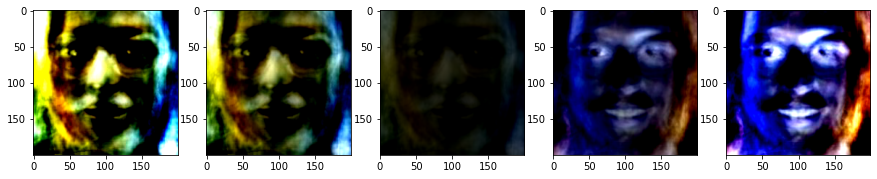

In [218]:
fig = plt.figure(figsize=(15,6))
columns = 5
rows = 1
for i in range(columns*rows):
    img = (xs[i] @ S2[:,sfs2.get_support()].T).reshape([200,200,3])
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img/10)
plt.show()

# 9

# 10